In [1]:
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn
import warnings
import numpy as np

df = pd.read_csv('./geocoded-cities-master.csv')
df.head()

,city,lat,lon,pm25_2020_11_27,pm25_2020_11_28,pm25_2020_11_29,pm25_2020_11_30,pm25_2020_12_01,pm25_2020_12_02,pm25_2020_12_03,...,pm25_2021_05_28,pm25_2021_05_29,pm25_2021_05_30,pm25_2021_05_31,pm25_2021_06_01,pm25_2021_06_02,pm25_2021_06_03,pm25_2021_06_04,pm25_2021_06_05,pm25_2021_06_06
0,NewYork,40.6943,-73.9249,0.45667,17.49792,10.24292,11.54875,5.03500,4.08833,1.84167,...,3.55375,2.05125,2.41750,6.24292,13.24083,11.66125,5.58000,6.05667,15.74625,21.80208
1,LosAngeles,34.1139,-118.4068,0.63375,7.34375,8.90917,8.91833,11.96667,15.81917,11.11167,...,31.28083,13.81833,23.13958,20.26250,21.35750,19.23000,22.81417,19.59958,14.33833,7.36500
2,Chicago,41.8373,-87.6862,0.35542,13.52375,5.70083,5.13917,1.22125,6.20292,14.05000,...,1.23208,1.60875,6.21250,10.51667,18.44542,14.50417,23.32000,7.54542,9.14250,4.33250
3,Miami,25.7839,-80.2102,0.25167,7.15250,8.82083,6.50167,3.95708,5.63667,5.26333,...,6.96875,4.72250,3.38083,3.48667,1.31000,1.74958,2.81208,4.98542,5.83750,7.32958
4,Dallas,32.7936,-96.7662,0.34708,9.69750,8.86625,4.15458,6.73125,4.25625,4.28708,...,6.12667,5.00042,5.13000,6.27833,6.74875,6.90167,4.91458,9.17167,4.75625,3.73833


In [2]:
print(df)

                city      lat       lon  pm25_2020_11_27  pm25_2020_11_28  \
0            NewYork  40.6943  -73.9249          0.45667         17.49792   
1         LosAngeles  34.1139 -118.4068          0.63375          7.34375   
2            Chicago  41.8373  -87.6862          0.35542         13.52375   
3              Miami  25.7839  -80.2102          0.25167          7.15250   
4             Dallas  32.7936  -96.7662          0.34708          9.69750   
...              ...      ...       ...              ...              ...   
3337       Edgewater  40.8237  -73.9740          0.61875         17.12750   
3338       GlennDale  38.9833  -76.8040          0.22458         21.11208   
3339  WesternSprings  41.8022  -87.9006          0.28708          9.43167   
3340        Okmulgee  35.6136  -96.0069          0.24958          6.08125   
3341        DeRidder  30.8467  -93.2931          0.24958          3.83708   

      pm25_2020_11_29  pm25_2020_11_30  pm25_2020_12_01  pm25_2020_12_02  \

In [3]:
columns = list(df.columns.values)

In [4]:
from sklearn.preprocessing import Normalizer

features = list(df.columns.values)
#target
y = df.loc[:, ['pm25_2021_06_06']].values
#features
del features[:3]
del features[-1]

# print(features)
x = df.loc[:, features].values


x = Normalizer().fit_transform(x)

In [5]:
print(x)

[[0.00138258 0.05297528 0.03101063 ... 0.01689355 0.01833668 0.04767207]
 [0.00150679 0.01746032 0.02118222 ... 0.0542424  0.04659947 0.03409046]
 [0.00146778 0.05584906 0.02354273 ... 0.09630465 0.03116034 0.0377558 ]
 ...
 [0.00172235 0.05658588 0.02312579 ... 0.07390457 0.04187442 0.04987135]
 [0.00298387 0.07270485 0.04142607 ... 0.0450626  0.03722668 0.04308491]
 [0.00296497 0.04558385 0.0937764  ... 0.09701864 0.05336027 0.02663553]]


In [6]:
len(x[0])

191

In [7]:
num_of_comp=inp=list(range(2,191))

In [8]:
# function for training PCA with train set and validation set to find out which set of kfold and which component performs best
def pca_graph(i,X_train , X_test,Y_train , Y_test):
    pca = PCA(n_components=i)
    X_train = pca.fit_transform(X_train)
    X_test=pca.transform(X_test)
    train_pca, dev_pca, train_labels_pca, dev_labels_pca = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)
    #pca_r2=[]
    #pca_var=[]
    #dimensions=[]
    model = LinearRegression()
    model.fit(train_pca, train_labels_pca)
    #print (model.intercept_)
    #print ('Coefficients: \n', model.coef_)
    res_sum_square= np.mean((model.predict(dev_pca) - dev_labels_pca ** 2))
    #print("Residual sum of squares %.2f"% res_sum_square)
    var_val=model.score(dev_pca, dev_labels_pca)
    #print ('Variance score: %.2f' %var_val)
    Y_test_predict = model.predict(dev_pca)
    r2_val=r2_score(dev_labels_pca,Y_test_predict)
    #print ('R Square', r2_val )
    #dimensions.append(2)
    #pca_var.append(var_val)
    #pca_r2.append(r2_val)
    return model.intercept_,model.coef_,res_sum_square,var_val,r2_val

In [9]:
# function for using test set for PCA with best set from the kfold
def PCA_result_graph(i,X_train , X_test,Y_train , Y_test):
    pca = PCA(n_components=i)
    X_train = pca.fit_transform(X_train)
    X_test=pca.transform(X_test)
    #train_pca, dev_pca, train_labels_pca, dev_labels_pca = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)
    #pca_r2=[]
    #pca_var=[]
    #dimensions=[]
    model = LinearRegression()
    model.fit(X_train, Y_train)
    #print (model.intercept_)
    #print ('Coefficients: \n', model.coef_)
    res_sum_square= np.mean((model.predict(X_test) - Y_test ** 2))
    #print("Residual sum of squares %.2f"% res_sum_square)
    var_val=model.score(X_test, Y_test)
    #print ('Variance score: %.2f' %var_val)
    Y_test_predict = model.predict(X_test)
    r2_val=r2_score(Y_test,Y_test_predict)
    #print ('R Square', r2_val )
    #dimensions.append(2)
    #pca_var.append(var_val)
    #pca_r2.append(r2_val)
    return var_val,r2_val

In [10]:
import pandas as pd 
import numpy as np
import operator
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import sys
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# from gensim.models import Word2Vec
# from gensim.test.utils import common_texts, get_tmpfile
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# from keras.models import Sequential, Model
# from keras.layers import Activation, Dense, Dropout, Input
# from keras import optimizers, regularizers
from sklearn.preprocessing import LabelEncoder
# from keras.utils.np_utils import to_categorical
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
from sklearn.decomposition import PCA
sns.set_style("whitegrid")
from sklearn.model_selection import KFold
np.random.seed(697)
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score


from sklearn.linear_model import LinearRegression

In [11]:
from sklearn.model_selection import train_test_split

kf5 = KFold(n_splits=2, shuffle=True) # HEre we can use any crossvalidation technique by simply changing this line and for loop alone
#loo = LeaveOneOut()
#print(loo)
count=0
count_dict={}
count_best_dict={}
dict_best_set={}
d={}
dict_best_comp={}
 # contains key as number of components and value as list of metrics
for training_index, test_index in kf5.split(x):
#for training_index, test_index in loo.split(X):  
    #count_dict={}
    X_train , X_test = x[training_index,:],x[test_index,:]
    Y_train , Y_test = y[training_index] , y[test_index]
    count+=1
    X_trainbest,X_testbest,Y_trainbest,Y_testbest= X_train , X_test,Y_train , Y_test
    count_dict['X_trainbest']=X_trainbest
    count_dict['X_testbest']=X_testbest
    count_dict['Y_trainbest']=Y_trainbest
    count_dict['Y_testbest']=Y_testbest
    count_best_dict[count]=count_dict.copy() #for finding and saving the best set of training and testing data which have high Rsquare
    #count_dict.clear()
    for i in num_of_comp:
      #dict_best_comp={}
      #d={}
      metricslist=[]
      model_intercept,model_coef,res_sum_square,variance_score,Rsquare = pca_graph(i,X_train , X_test,Y_train , Y_test)
      metricslist=[model_intercept,model_coef,res_sum_square,variance_score,Rsquare]
      d['model_intercept']=model_intercept
      d['model_coef']=model_coef
      d['res_sum_square']=res_sum_square
      d['variance_score']=variance_score
      d['Rsquare']=Rsquare
      dict_best_comp[i]=d.copy()
      #d.clear()
    dict_best_set[count]=dict_best_comp.copy() #saving all the metrics in PCA for n number of components and N number of set of data(kfold split)
    #dict_best_comp.clear()


In [12]:
#choosing the  metrics, Here we used Rsquare, finding out which set that higher accuracy achieved

best=-100
sets=0
for i in dict_best_set:
  #print(i)
  for j in dict_best_set[i]:
    #print(i,j)
     #for k in dict_best_set[i][j]:
    print("set : "+str(i)+" "+"comp"+" "+str(j)+" " + "Rsquare" +" "+ str(dict_best_set[i][j]["Rsquare"] ))
    if dict_best_set[i][j]["Rsquare"] >= best:
      best=dict_best_set[i][j]["Rsquare"]
      sets=i

set : 1 comp 2 Rsquare 0.5349085043538256
set : 1 comp 3 Rsquare 0.5829101332497355
set : 1 comp 4 Rsquare 0.6090090386126552
set : 1 comp 5 Rsquare 0.6229180551179455
set : 1 comp 6 Rsquare 0.622242070813738
set : 1 comp 7 Rsquare 0.6226418695829573
set : 1 comp 8 Rsquare 0.628334250746619
set : 1 comp 9 Rsquare 0.6376350873559165
set : 1 comp 10 Rsquare 0.644857340730813
set : 1 comp 11 Rsquare 0.6520019740586644
set : 1 comp 12 Rsquare 0.6598779955756412
set : 1 comp 13 Rsquare 0.6603551336145382
set : 1 comp 14 Rsquare 0.7010075881348645
set : 1 comp 15 Rsquare 0.7209699951956233
set : 1 comp 16 Rsquare 0.7284525610501548
set : 1 comp 17 Rsquare 0.7271718612600264
set : 1 comp 18 Rsquare 0.7301673766476859
set : 1 comp 19 Rsquare 0.7308750662890162
set : 1 comp 20 Rsquare 0.7297962691798406
set : 1 comp 21 Rsquare 0.7547553129023975
set : 1 comp 22 Rsquare 0.7536780467292219
set : 1 comp 23 Rsquare 0.7774826985686468
set : 1 comp 24 Rsquare 0.7783016564884726
set : 1 comp 25 Rsquar

In [13]:
#using the best set to call PCA function to use the test set with all components
bestR2PCA=[]
bestvarPCA=[]
bestsetfortest={}
for i in count_best_dict:
  if i == sets:
    for j in count_best_dict[sets]:
      if 'X_testbest'==j:
        X_ttbest=count_best_dict[sets][j]
      elif 'X_trainbest' ==j:
        X_tnbest=count_best_dict[sets][j]
      elif 'Y_testbest' ==j:
        Y_ttbest=count_best_dict[sets][j]
      elif 'Y_trainbest'==j:
        Y_tnbest=count_best_dict[sets][j]
for i in num_of_comp:   
    variance,R2=PCA_result_graph(i,X_tnbest , X_ttbest,Y_tnbest , Y_ttbest)
    bestR2PCA.append(R2)
    bestvarPCA.append(variance)
print(bestR2PCA)
print(bestvarPCA)

[0.5637845125832361, 0.6343322057111729, 0.6417842270102495, 0.6700005456600135, 0.6716339759657219, 0.6717288279410295, 0.6792814595878756, 0.6878650100478938, 0.6962008255265388, 0.6967141335455583, 0.7027160354945533, 0.7008722483215921, 0.7306230527122599, 0.7730384270513662, 0.7734307665546022, 0.7784125208201438, 0.7782019925960402, 0.7783850437314481, 0.7792961550855348, 0.8239070175286851, 0.8279214651971301, 0.8335107610991319, 0.8339997137198483, 0.8333702992781971, 0.8337384167898665, 0.8342126070746742, 0.8340418485104424, 0.8355100574163106, 0.8452469908822207, 0.8527874121021051, 0.8531939477006538, 0.8535162868536745, 0.8524234565733106, 0.8535919011089885, 0.8567157011191489, 0.8584299016563808, 0.8564476297535706, 0.8600456683473796, 0.8592392417929434, 0.8635065375615217, 0.8632682146687812, 0.8635006039598094, 0.8629762011041597, 0.8641701376802529, 0.8634882798984335, 0.8639966366265137, 0.863205366587963, 0.8664867164345288, 0.8649583463107956, 0.8664294832326946, 

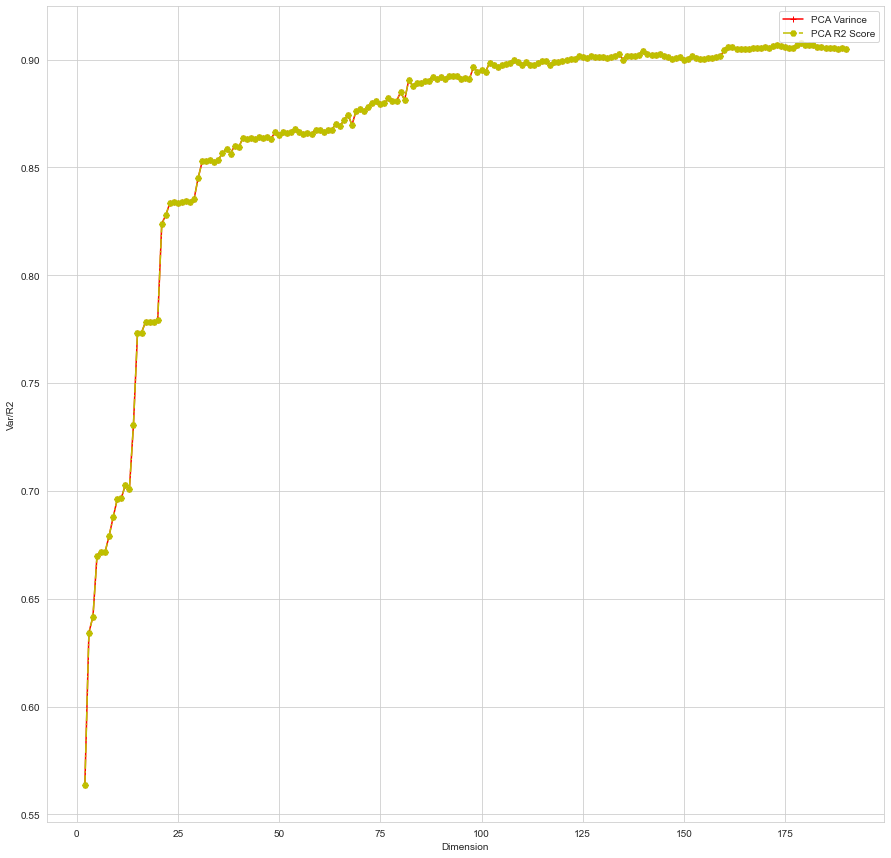

In [14]:
#plotting the graph for PCA
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.plot(num_of_comp, bestvarPCA, label = "PCA Varince", linestyle='-', marker='+', color='r')
plt.plot(num_of_comp,bestR2PCA,  label = "PCA R2 Score",linestyle='-.', marker='H', color='y')
plt.xlabel('Dimension')
plt.ylabel('Var/R2')
plt.legend()
plt.show()

** rest of the code


In [20]:
df.head()

,city,lat,lon,pm25_2020_11_27,pm25_2020_11_28,pm25_2020_11_29,pm25_2020_11_30,pm25_2020_12_01,pm25_2020_12_02,pm25_2020_12_03,...,pm25_2021_05_28,pm25_2021_05_29,pm25_2021_05_30,pm25_2021_05_31,pm25_2021_06_01,pm25_2021_06_02,pm25_2021_06_03,pm25_2021_06_04,pm25_2021_06_05,pm25_2021_06_06
0,NewYork,40.6943,-73.9249,0.45667,17.49792,10.24292,11.54875,5.03500,4.08833,1.84167,...,3.55375,2.05125,2.41750,6.24292,13.24083,11.66125,5.58000,6.05667,15.74625,21.80208
1,LosAngeles,34.1139,-118.4068,0.63375,7.34375,8.90917,8.91833,11.96667,15.81917,11.11167,...,31.28083,13.81833,23.13958,20.26250,21.35750,19.23000,22.81417,19.59958,14.33833,7.36500
2,Chicago,41.8373,-87.6862,0.35542,13.52375,5.70083,5.13917,1.22125,6.20292,14.05000,...,1.23208,1.60875,6.21250,10.51667,18.44542,14.50417,23.32000,7.54542,9.14250,4.33250
3,Miami,25.7839,-80.2102,0.25167,7.15250,8.82083,6.50167,3.95708,5.63667,5.26333,...,6.96875,4.72250,3.38083,3.48667,1.31000,1.74958,2.81208,4.98542,5.83750,7.32958
4,Dallas,32.7936,-96.7662,0.34708,9.69750,8.86625,4.15458,6.73125,4.25625,4.28708,...,6.12667,5.00042,5.13000,6.27833,6.74875,6.90167,4.91458,9.17167,4.75625,3.73833


In [7]:
plt.figure(figsize=(14,7))

sns.heatmap(data=num_of_comp, annot=True)
plt.xlabel("Dimension")

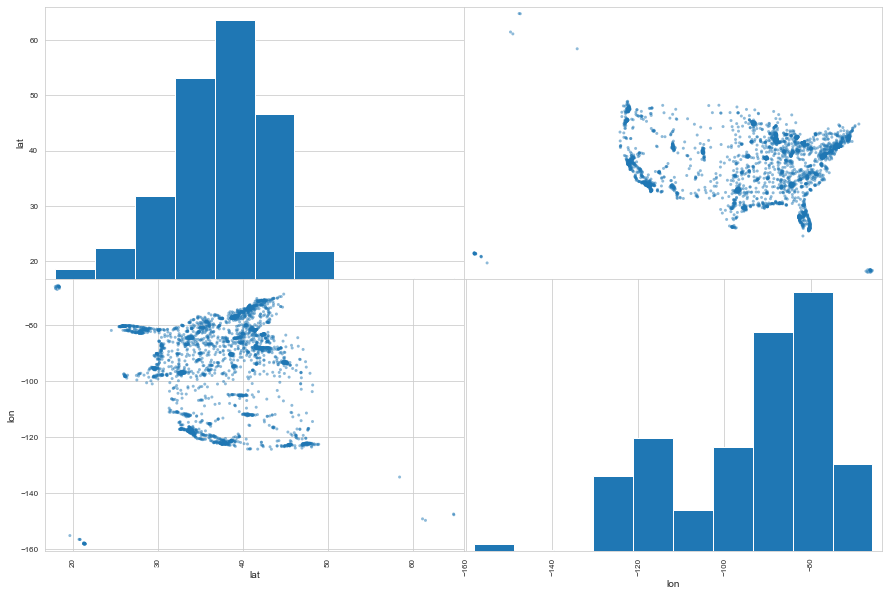

In [23]:
numeric_columns = ['lat', 'lon']
pd.plotting.scatter_matrix(df[numeric_columns], 
                             # Make figure large to show details
                             figsize = (15,10), 
                           # Lower point opacity to show overlap
                           alpha = 0.5)

plt.show()

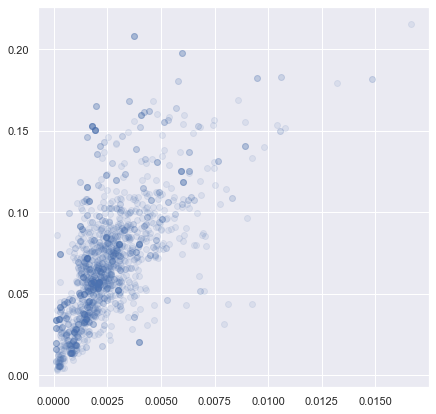

In [43]:
plt.figure(figsize = (7,7))
plt.scatter(X_train[:,0],X_train[:,1], alpha=0.1)
plt.show()

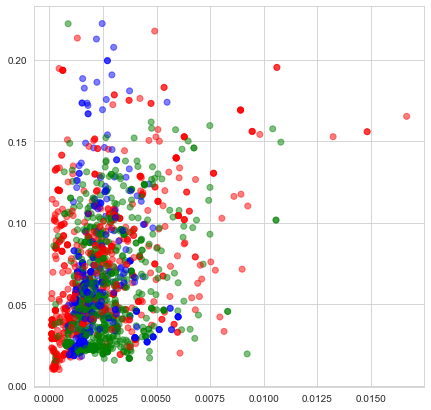

In [39]:
# X_train
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_train)

# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g',2 : 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(X_train[:,0],X_train[:,2], c= label_color, alpha=0.5) 
plt.show()